<center><h1>ECSE 415 Course Project - Counting People in a
Shopping Mall</h1>
<h4>SVM with Haar Features (Part 2)</h4></center>

<h3>Team Members:</h3>
<center>
Lawrence Zhang, 260664442<br>
Yinuo Wang, 260766084<br>
Fei Peng, 260712440<br>
Yukai Zhang, 260710915<br>
</center>

# Install detectron2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd '/content/gdrive/My Drive/ECSE_415_Project/frames/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1oHyE7rxbw-bo9WbZ2w2kPnRlpwBVEAKl/ECSE_415_Project/frames


In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
import os
import random

In [ ]:
path = "./"
files = sorted(os.listdir(path))
count_people = []
positive_patches = []
for file in iter(files):
    im = cv2.imread(path + file)
    # im = cv2.imread("./seq_002000.jpg")
    cfg = get_cfg()
    # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)
    outputs = predictor(im)
    boxes = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 0]
    count_people.append(len(boxes))
    positive_patches.append(boxes)
    print("Frame: {}, number of people: {}".format(file, len(boxes)))

model_final_f10217.pkl: 178MB [00:16, 11.0MB/s]                           
/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


Frame: seq_000001.jpg, number of people: 25
Frame: seq_000002.jpg, number of people: 32
Frame: seq_000003.jpg, number of people: 32
Frame: seq_000004.jpg, number of people: 34
Frame: seq_000005.jpg, number of people: 33
Frame: seq_000006.jpg, number of people: 25
Frame: seq_000007.jpg, number of people: 30
Frame: seq_000008.jpg, number of people: 31
Frame: seq_000009.jpg, number of people: 17
Frame: seq_000010.jpg, number of people: 22
Frame: seq_000011.jpg, number of people: 14
Frame: seq_000012.jpg, number of people: 15
Frame: seq_000013.jpg, number of people: 18
Frame: seq_000014.jpg, number of people: 18
Frame: seq_000015.jpg, number of people: 11
Frame: seq_000016.jpg, number of people: 15
Frame: seq_000017.jpg, number of people: 11
Frame: seq_000018.jpg, number of people: 21
Frame: seq_000019.jpg, number of people: 25
Frame: seq_000020.jpg, number of people: 25
Frame: seq_000021.jpg, number of people: 25
Frame: seq_000022.jpg, number of people: 18
Frame: seq_000023.jpg, number of

## Generate Positive Data

In [ ]:
numpy_patches = []
for i, patches in enumerate(positive_patches):
    numpy_patches.append(patches.tensor.cpu().numpy().squeeze())

## Generate Negative Data

In [ ]:
x_coor_list = np.linspace(0, 640, num=80, endpoint=False) # horizontal
y_coor_list = np.linspace(0, 480, num=20, endpoint=False) # vertical

coor_samples = []

# for people_box in random.sample(numpy_patches, 200):
for people_box in numpy_patches:

    coor_list = []

    for i, y in enumerate(y_coor_list):
        for j, x in enumerate(x_coor_list):
            x_check = len(people_box[people_box[:,2]<x])+len(people_box[people_box[:,0]>(x+48)])
            y_check = len(people_box[people_box[:,3]<y])+len(people_box[people_box[:,1]>(y+144)])
            if(x_check == people_box.shape[0] or y_check == people_box.shape[0]):
                coor_list.append([x,y,(x+48),(y+144)])

    for i, y in enumerate(y_coor_list):
        for j, x in enumerate(x_coor_list):
            x_check = len(people_box[people_box[:,2]<x])+len(people_box[people_box[:,0]>(x+32)])
            y_check = len(people_box[people_box[:,3]<y])+len(people_box[people_box[:,1]>(y+96)])
            if(x_check == people_box.shape[0] or y_check == people_box.shape[0]):
                coor_list.append([x,y,(x+32),(y+96)])

    for i, y in enumerate(y_coor_list):
        for j, x in enumerate(x_coor_list):
            x_check = len(people_box[people_box[:,2]<x])+len(people_box[people_box[:,0]>(x+24)])
            y_check = len(people_box[people_box[:,3]<y])+len(people_box[people_box[:,1]>(y+72)])
            if(x_check == people_box.shape[0] or y_check == people_box.shape[0]):
                coor_list.append([x,y,(x+32),(y+96)])

    for i, y in enumerate(y_coor_list):
        for j, x in enumerate(x_coor_list):
            x_check = len(people_box[people_box[:,2]<x])+len(people_box[people_box[:,0]>(x+16)])
            y_check = len(people_box[people_box[:,3]<y])+len(people_box[people_box[:,1]>(y+48)])
            if(x_check == people_box.shape[0] or y_check == people_box.shape[0]):
                coor_list.append([x,y,(x+16),(y+48)])

    coor_samples.append(random.sample(coor_list, min(len(people_box),len(coor_list))))

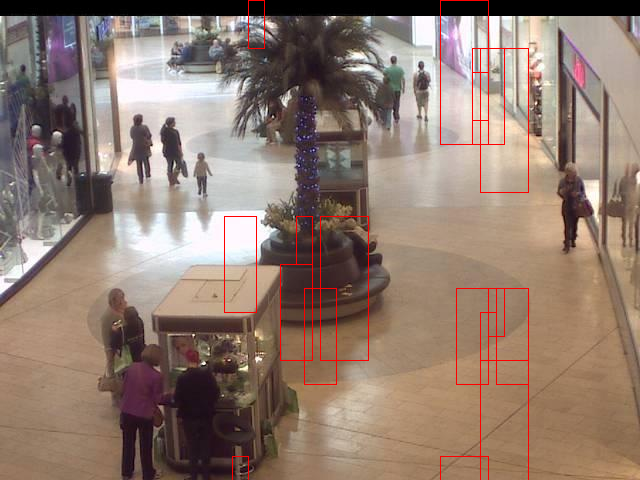

In [ ]:
image = cv2.imread(path + files[526])
output = image.copy()
for coor_sample in iter(coor_samples[526]):
    output = cv2.rectangle(output,(int(coor_sample[0]), int(coor_sample[1])),(int(coor_sample[2]), int(coor_sample[3])),(0,0,255),1)
cv2_imshow(output)

## Dump Data

In [ ]:
from numpy import asarray
from numpy import save
save('../Data/numpy_patches.npy', np.asarray(numpy_patches))
save('../Data/count_people.npy', np.asarray(count_people))
save('../Data/coor_samples.npy', np.asarray(coor_samples))

## Load Data (Start of part 2)
#### Training SVM using Haar starts from here. Please run the import again if you did not run the previous Detectron2 part.
#### Also, please take care of the directory in the SVM part if you want to run.

In [ ]:
# load patches from previous Detectron2 part
# those patches will be used as ground truth

from numpy import load
numpy_patches = load('../Data/numpy_patches.npy', allow_pickle=True)
count_people = load('../Data/count_people.npy', allow_pickle=True)
coor_samples = load('../Data/coor_samples.npy', allow_pickle=True)

In [ ]:
path = "./"
files = sorted(os.listdir(path))

# Haar Feature

In [ ]:
from skimage.transform import integral_image
from skimage.feature import haar_like_feature

In [ ]:
def compute_haar(images):
    features = []
    #img_size = (24, 8) # h x w in pixels
    img_size = (5,12) # h x w in pixels
    index = 0
    for image in images:
        # resize the images
        resized = cv2.resize(image, img_size, interpolation=cv2.INTER_AREA)
 
        ii = integral_image(resized)
        features.append(haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1], feature_type=['type-2-y']).reshape(1, -1))

    features = np.vstack(features)
    return features

In [ ]:
import matplotlib.pyplot as plt

# The number of image used as dataset for SVM training
# Note one img might have 20-30 patches. Thus the entire example is around
# (image_number * 20)
image_number = 100

In [ ]:
# Extracting Haar features from positive patches 

num_img = np.arange(0,2000)
path = "./"
files = sorted(os.listdir(path))
sub_list = []

for i in random.sample(list(num_img), image_number):
    im = cv2.imread(path + files[i], cv2.IMREAD_GRAYSCALE)
    for coor in numpy_patches[i]:
        coor = coor.astype(int)
        sub_list.append(im[coor[1]:coor[3],coor[0]:coor[2]])

pos_haar = compute_haar(sub_list)
print("finished")

finished


In [ ]:
print(len(pos_haar))
print(pos_haar[0].shape)
print(max(pos_haar[0]))
print(min(pos_haar[0]))

2367
(462,)
4586895649137554910
-9152552958491404144


In [ ]:
# Extracting Haar features from negative patches 

num_img = np.arange(0,2000)
path = "./"
files = sorted(os.listdir(path))
sub_list = []
for i in random.sample(list(num_img), image_number):
    im = cv2.imread(path + files[i], cv2.IMREAD_GRAYSCALE)
    for coor in coor_samples[i]:
        coor = np.asarray(coor, dtype=int)
        sub_list.append(im[coor[1]:coor[3],coor[0]:coor[2]])

neg_haar = compute_haar(sub_list)
print("finished")

finished


In [ ]:
print(len(neg_haar))
print(neg_haar[0].shape)

2373
(462,)


# Train SVC

In [ ]:
from sklearn import svm

In [ ]:
# get a SVM

clf = svm.SVC(gamma='auto', kernel='linear')
train_X = np.concatenate((np.asarray(pos_haar), np.asarray(neg_haar)))
train_y = np.concatenate((np.ones(len(pos_haar)),np.zeros(len(neg_haar))))
# clf.fit(train_X, train_y)

In [ ]:
# split train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=0)

In [ ]:
# scaling the data
# from previous cells in the HAAR extraction, Haar features contain a lot of extremely large values
# thus need to be normailized

from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)

X_train = scaling.transform(X_train)

X_test = scaling.transform(X_test)

clf.fit(X_train, y_train)
print("finished")

finished


In [ ]:
# test cell
from sklearn.metrics import accuracy_score
print(X_test.shape)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

(948, 462)


0.8670886075949367

## Dump clf (SVM)

In [ ]:
# save the svm classifier outside

from sklearn.externals import joblib
joblib.dump(clf, '../Data/haar_svc.npy')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['../Data/haar_svc.npy']

## Load clf (SVM)

In [ ]:
# load existing SVM

clf = joblib.load('../Data/haar_svc.npy')

In [ ]:
# test the old svm loaded
# (can skip this cell)

from sklearn.metrics import accuracy_score
print(X_test.shape)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

(948, 462)


0.8670886075949367

# Pyramid Sliding Window

In [ ]:
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            yield (x, y, image[y: y + window_size[0], x: x + window_size[1]])

In [ ]:
def pyramid(image, scale=1.5, min_size=(145, 200)):
    yield image
    while True:
        h = int(image.shape[0] / scale)
        w = int(image.shape[1] / scale)
        image = cv2.resize(image, (h, w), interpolation=cv2.INTER_AREA)
        if image.shape[0] < min_size[0] or image.shape[1] < min_size[1]:
            break
        yield image

# Non-Maximum Suppression and People Counting

In [ ]:
from time import time
from imutils.object_detection import non_max_suppression
from sklearn.metrics import mean_squared_error

In [ ]:
import gc

In [ ]:
# take in an image and apply sliding window, each window is analyzed by the SVM
# In the end, the duplicate detection will be merged or removed by non max supression

def svm_count(img_no, det_thresh):
    tic = time()
    image = cv2.imread(path + files[img_no], cv2.IMREAD_GRAYSCALE)
    win_w = 27
    win_h = 81
    pred = 0
    svm_boxes = []
    sc = []
    frac = 1
    clf = joblib.load('../Data/haar_svc.npy')
    
    for resized in pyramid(image, scale=1.5):

        for (x, y, window) in sliding_window(resized, step_size=10, window_size=(win_h, win_w)):
            if window.shape[0] != win_h or window.shape[1] != win_w:
                continue
            clone = window.copy()
            clone = (clone,)
            
            haar_clone = compute_haar(clone)
            haar_clone = scaling.transform(haar_clone)
            pred = clf.predict(haar_clone)
            if pred:
                if clf.decision_function(haar_clone) > det_thresh:
                    sc.append(clf.decision_function(haar_clone))
                    svm_boxes.append([int(x*frac), int(y*frac), int((x+win_w)*frac), int((y+win_h)*frac)])
        frac *= 1.5
    
    # people counting with non-maximum suppression
    pick = non_max_suppression(np.asarray(svm_boxes), probs=np.asarray(sc).squeeze(), overlapThresh=0.1)
    gc.collect()
    # return len(pick)
    return pick

# Example of Result (Haar Feature)

In [ ]:
det_threshold = 1.8

svm_people_count = []
svm_people_count = svm_count(1554, det_threshold)
svm_people_count.shape

(36, 4)

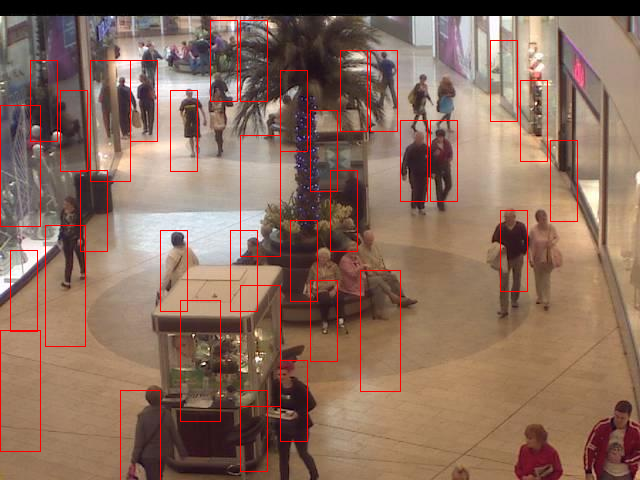

In [ ]:
image = cv2.imread(path + files[1554])
output = image.copy()
for svm_box in iter(svm_people_count):
    output = cv2.rectangle(output,(int(svm_box[0]), int(svm_box[1])),(int(svm_box[2]), int(svm_box[3])),(0,0,255),1)
cv2_imshow(output)

Ground Truth


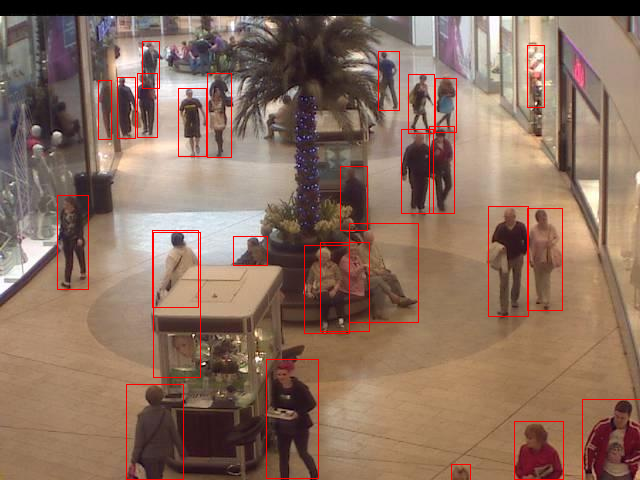

In [ ]:
# show ground truth

image = cv2.imread(path + files[1554])
output = image.copy()
for svm_box in numpy_patches[1554]:
    output = cv2.rectangle(output,(int(svm_box[0]), int(svm_box[1])),(int(svm_box[2]), int(svm_box[3])),(0,0,255),1)
print("Ground Truth")
cv2_imshow(output)

# IoU Calculation

In [ ]:
IoU = []

# choose an iteration below to either run all 2000
haar_count = []
for i in range(2000):
    
    svm_image_mask = np.zeros((640,480), dtype=int)
    fb_image_mask = np.zeros((640,480), dtype=int)
    svm_count_peoples = svm_count(i, det_threshold)
    haar_count.append(len(svm_count_peoples))
    for svm_count_people in svm_count_peoples:
        svm_image_mask[svm_count_people[0]:svm_count_people[2], svm_count_people[1]:svm_count_people[3]] = 1
    for fb_count_people in numpy_patches[i]:
        fb_count_people = fb_count_people.astype(int)
        fb_image_mask[fb_count_people[0]:fb_count_people[2], fb_count_people[1]:fb_count_people[3]] = 1
    sum_image_mask = (fb_image_mask + svm_image_mask).reshape(-1)
    IoU.append(np.sum(sum_image_mask == 2) / np.sum(sum_image_mask > 0))
    print("Image: {}, IoU: {}, number of people: {}".format(i+1, IoU[-1], haar_count[-1]))
    
print(np.mean(IoU))

Image: 1, IoU: 0.2382031116430159, number of people: 23
Image: 2, IoU: 0.29316443782109103, number of people: 31
Image: 3, IoU: 0.23657856974740152, number of people: 30
Image: 4, IoU: 0.30619504496605626, number of people: 27
Image: 5, IoU: 0.28019401883200146, number of people: 34
Image: 6, IoU: 0.23747934859570452, number of people: 40
Image: 7, IoU: 0.2649954539550591, number of people: 25
Image: 8, IoU: 0.31721076645562907, number of people: 28
Image: 9, IoU: 0.1673921492421298, number of people: 28
Image: 10, IoU: 0.21225370872181143, number of people: 24
Image: 11, IoU: 0.12365898332500773, number of people: 23
Image: 12, IoU: 0.13281659552160563, number of people: 25
Image: 13, IoU: 0.22949380452297605, number of people: 22
Image: 14, IoU: 0.26635763391128736, number of people: 27
Image: 15, IoU: 0.11505479825909594, number of people: 20
Image: 16, IoU: 0.1491933438181726, number of people: 20
Image: 17, IoU: 0.1817963560701043, number of people: 20
Image: 18, IoU: 0.2804698480

Image: 143, IoU: 0.2688132274556728, number of people: 26
Image: 144, IoU: 0.24889854727316027, number of people: 29
Image: 145, IoU: 0.21112864734631015, number of people: 31
Image: 146, IoU: 0.2735740512004873, number of people: 30
Image: 147, IoU: 0.24724446217154863, number of people: 22
Image: 148, IoU: 0.28808983911024727, number of people: 25
Image: 149, IoU: 0.3107967912094335, number of people: 30
Image: 150, IoU: 0.3110245971424591, number of people: 36
Image: 151, IoU: 0.2529252451947096, number of people: 27
Image: 152, IoU: 0.2189493843479709, number of people: 29
Image: 153, IoU: 0.24544471330107054, number of people: 31
Image: 154, IoU: 0.26797081714216126, number of people: 29
Image: 155, IoU: 0.2460194669121247, number of people: 28
Image: 156, IoU: 0.23472992283509575, number of people: 23
Image: 157, IoU: 0.3019020569756433, number of people: 29
Image: 158, IoU: 0.22928623737588774, number of people: 32
Image: 159, IoU: 0.2707494490563537, number of people: 32
Image:

Image: 284, IoU: 0.2667306173118158, number of people: 26
Image: 285, IoU: 0.2800863802452135, number of people: 35
Image: 286, IoU: 0.2930673332243169, number of people: 30
Image: 287, IoU: 0.2938212038221482, number of people: 32
Image: 288, IoU: 0.20547760518484992, number of people: 24
Image: 289, IoU: 0.24732620320855614, number of people: 30
Image: 290, IoU: 0.21150167931107064, number of people: 30
Image: 291, IoU: 0.2961285068136535, number of people: 38
Image: 292, IoU: 0.3052498195052233, number of people: 38
Image: 293, IoU: 0.2623381140074857, number of people: 33
Image: 294, IoU: 0.27607317775857104, number of people: 26
Image: 295, IoU: 0.20842635643037094, number of people: 26
Image: 296, IoU: 0.18889892492069088, number of people: 24
Image: 297, IoU: 0.218621134623117, number of people: 24
Image: 298, IoU: 0.24796004559656878, number of people: 31
Image: 299, IoU: 0.29856302959855796, number of people: 32
Image: 300, IoU: 0.2226389567439588, number of people: 32
Image: 

Image: 424, IoU: 0.3268596660581674, number of people: 25
Image: 425, IoU: 0.30383261691140406, number of people: 34
Image: 426, IoU: 0.2610642689710667, number of people: 30
Image: 427, IoU: 0.2693889334402566, number of people: 37
Image: 428, IoU: 0.24871049082982108, number of people: 37
Image: 429, IoU: 0.206503796632552, number of people: 31
Image: 430, IoU: 0.21281262327416173, number of people: 29
Image: 431, IoU: 0.2761219357252878, number of people: 34
Image: 432, IoU: 0.2502192403190871, number of people: 27
Image: 433, IoU: 0.19704820856100166, number of people: 21
Image: 434, IoU: 0.1623213788162242, number of people: 23
Image: 435, IoU: 0.17806867123943212, number of people: 23
Image: 436, IoU: 0.2078311903588549, number of people: 24
Image: 437, IoU: 0.18110341151385928, number of people: 23
Image: 438, IoU: 0.22976649146345968, number of people: 23
Image: 439, IoU: 0.1790991609055887, number of people: 20
Image: 440, IoU: 0.17655002741044806, number of people: 19
Image: 

Image: 564, IoU: 0.2885562132444496, number of people: 25
Image: 565, IoU: 0.21570935430932037, number of people: 25
Image: 566, IoU: 0.2286171937958274, number of people: 27
Image: 567, IoU: 0.23756207674943566, number of people: 31
Image: 568, IoU: 0.20652726902726903, number of people: 30
Image: 569, IoU: 0.25804888181125807, number of people: 30
Image: 570, IoU: 0.1509447243255201, number of people: 25
Image: 571, IoU: 0.18142619506216073, number of people: 29
Image: 572, IoU: 0.2605952058645896, number of people: 26
Image: 573, IoU: 0.22981840693355346, number of people: 24
Image: 574, IoU: 0.19542235345130185, number of people: 26
Image: 575, IoU: 0.23835447300482657, number of people: 26
Image: 576, IoU: 0.21924521344214887, number of people: 24
Image: 577, IoU: 0.20519073102575594, number of people: 20
Image: 578, IoU: 0.2689495066744051, number of people: 22
Image: 579, IoU: 0.18017797371213976, number of people: 25
Image: 580, IoU: 0.2783900391586747, number of people: 29
Ima

Image: 704, IoU: 0.28498138275366, number of people: 30
Image: 705, IoU: 0.21812798010430925, number of people: 30
Image: 706, IoU: 0.2721929717154402, number of people: 30
Image: 707, IoU: 0.26425531134187064, number of people: 31
Image: 708, IoU: 0.3023536235423408, number of people: 35
Image: 709, IoU: 0.3208502731324308, number of people: 39
Image: 710, IoU: 0.3813024557040721, number of people: 30
Image: 711, IoU: 0.3066345080816444, number of people: 37
Image: 712, IoU: 0.35942878680011725, number of people: 32
Image: 713, IoU: 0.28784603401044995, number of people: 31
Image: 714, IoU: 0.31419475550839177, number of people: 31
Image: 715, IoU: 0.36699030865413895, number of people: 33
Image: 716, IoU: 0.29285038473453734, number of people: 33
Image: 717, IoU: 0.36177043468047415, number of people: 26
Image: 718, IoU: 0.2793907193262382, number of people: 28
Image: 719, IoU: 0.26805918975006765, number of people: 25
Image: 720, IoU: 0.313595909408842, number of people: 31
Image: 7

Image: 845, IoU: 0.25175432324491065, number of people: 29
Image: 846, IoU: 0.26253275443260715, number of people: 31
Image: 847, IoU: 0.280642152290245, number of people: 28
Image: 848, IoU: 0.3082313931083927, number of people: 29
Image: 849, IoU: 0.3151238816242257, number of people: 27
Image: 850, IoU: 0.3363988810914266, number of people: 28
Image: 851, IoU: 0.3384438592291118, number of people: 27
Image: 852, IoU: 0.209769198316578, number of people: 24
Image: 853, IoU: 0.1883547878985389, number of people: 25
Image: 854, IoU: 0.300123997266999, number of people: 25
Image: 855, IoU: 0.1452695465905034, number of people: 22
Image: 856, IoU: 0.2107026252867425, number of people: 22
Image: 857, IoU: 0.26679929733962626, number of people: 26
Image: 858, IoU: 0.27274733560768377, number of people: 28
Image: 859, IoU: 0.230349508572436, number of people: 30
Image: 860, IoU: 0.2822383973538398, number of people: 30
Image: 861, IoU: 0.28577865897620763, number of people: 32
Image: 862, I

Image: 986, IoU: 0.2933858693061756, number of people: 27
Image: 987, IoU: 0.32026482279827556, number of people: 35
Image: 988, IoU: 0.3254168802949291, number of people: 40
Image: 989, IoU: 0.3642829631531647, number of people: 37
Image: 990, IoU: 0.328615748840658, number of people: 39
Image: 991, IoU: 0.3895245243611918, number of people: 44
Image: 992, IoU: 0.35676061596504904, number of people: 37
Image: 993, IoU: 0.3026248421340069, number of people: 31
Image: 994, IoU: 0.3589689963291769, number of people: 33
Image: 995, IoU: 0.316253214854328, number of people: 35
Image: 996, IoU: 0.26855881141209187, number of people: 30
Image: 997, IoU: 0.32210702108412775, number of people: 29
Image: 998, IoU: 0.33758040067188333, number of people: 28
Image: 999, IoU: 0.279952755451848, number of people: 33
Image: 1000, IoU: 0.3008048677167174, number of people: 32
Image: 1001, IoU: 0.3746721249336669, number of people: 30
Image: 1002, IoU: 0.3208590779920309, number of people: 30
Image: 10

Image: 1124, IoU: 0.22447363210349153, number of people: 33
Image: 1125, IoU: 0.2390542533871064, number of people: 28
Image: 1126, IoU: 0.301896923409814, number of people: 31
Image: 1127, IoU: 0.29491252947912006, number of people: 35
Image: 1128, IoU: 0.3566309226346667, number of people: 32
Image: 1129, IoU: 0.2906071425326829, number of people: 28
Image: 1130, IoU: 0.3103470543736969, number of people: 26
Image: 1131, IoU: 0.2767506261326383, number of people: 28
Image: 1132, IoU: 0.28509462991454576, number of people: 29
Image: 1133, IoU: 0.32584644767590815, number of people: 34
Image: 1134, IoU: 0.24394213961544012, number of people: 31
Image: 1135, IoU: 0.23367176716655516, number of people: 29
Image: 1136, IoU: 0.217777739611332, number of people: 25
Image: 1137, IoU: 0.28781794893958085, number of people: 25
Image: 1138, IoU: 0.3117869754176287, number of people: 23
Image: 1139, IoU: 0.2976991383063489, number of people: 31
Image: 1140, IoU: 0.26354359083063317, number of pe

Image: 1263, IoU: 0.28192886675651596, number of people: 22
Image: 1264, IoU: 0.35260966806173744, number of people: 29
Image: 1265, IoU: 0.33141605039715144, number of people: 24
Image: 1266, IoU: 0.2760329812858996, number of people: 29
Image: 1267, IoU: 0.4201221631822019, number of people: 28
Image: 1268, IoU: 0.2902629278461435, number of people: 23
Image: 1269, IoU: 0.3213441661848685, number of people: 30
Image: 1270, IoU: 0.2512499511737823, number of people: 25
Image: 1271, IoU: 0.3524763847357269, number of people: 25
Image: 1272, IoU: 0.3319887758681164, number of people: 29
Image: 1273, IoU: 0.3021892939334571, number of people: 31
Image: 1274, IoU: 0.2437032768123118, number of people: 31
Image: 1275, IoU: 0.2386742296604141, number of people: 27
Image: 1276, IoU: 0.2638185309257292, number of people: 26
Image: 1277, IoU: 0.27983325687615934, number of people: 29
Image: 1278, IoU: 0.3106317556069337, number of people: 24
Image: 1279, IoU: 0.2429789249348804, number of peop

Image: 1402, IoU: 0.37336580634278005, number of people: 29
Image: 1403, IoU: 0.27271924888844756, number of people: 27
Image: 1404, IoU: 0.2956007296116738, number of people: 25
Image: 1405, IoU: 0.3118475960084669, number of people: 24
Image: 1406, IoU: 0.34782296220878, number of people: 23
Image: 1407, IoU: 0.2710286790380164, number of people: 25
Image: 1408, IoU: 0.2490621753157981, number of people: 24
Image: 1409, IoU: 0.24164260192844209, number of people: 27
Image: 1410, IoU: 0.2033113832523862, number of people: 27
Image: 1411, IoU: 0.24794234295705575, number of people: 26
Image: 1412, IoU: 0.25837036109894235, number of people: 23
Image: 1413, IoU: 0.253451828458087, number of people: 28
Image: 1414, IoU: 0.2625979434165586, number of people: 27
Image: 1415, IoU: 0.24902953964767582, number of people: 30
Image: 1416, IoU: 0.2678170053354524, number of people: 25
Image: 1417, IoU: 0.3088049703912242, number of people: 27
Image: 1418, IoU: 0.29014643104846194, number of peop

Image: 1540, IoU: 0.2588948895233509, number of people: 23
Image: 1541, IoU: 0.2544552142940558, number of people: 23
Image: 1542, IoU: 0.24670052771754736, number of people: 28
Image: 1543, IoU: 0.264875382344939, number of people: 31
Image: 1544, IoU: 0.24154152762328512, number of people: 32
Image: 1545, IoU: 0.2735828745424907, number of people: 28
Image: 1546, IoU: 0.3097289577349844, number of people: 33
Image: 1547, IoU: 0.2825531373066184, number of people: 26
Image: 1548, IoU: 0.32579934369178104, number of people: 26
Image: 1549, IoU: 0.30793650793650795, number of people: 26
Image: 1550, IoU: 0.27739969437435585, number of people: 29
Image: 1551, IoU: 0.327042215240973, number of people: 28
Image: 1552, IoU: 0.3006528968483998, number of people: 34
Image: 1553, IoU: 0.28134846406451347, number of people: 33
Image: 1554, IoU: 0.24344092860550168, number of people: 32
Image: 1555, IoU: 0.2771487859041101, number of people: 28
Image: 1556, IoU: 0.2701168889417752, number of peo

Image: 1678, IoU: 0.23663617434895448, number of people: 27
Image: 1679, IoU: 0.2846373308501575, number of people: 27
Image: 1680, IoU: 0.18982592114166205, number of people: 29
Image: 1681, IoU: 0.23812923955730098, number of people: 33
Image: 1682, IoU: 0.23845905346470683, number of people: 34
Image: 1683, IoU: 0.24423950670705322, number of people: 34
Image: 1684, IoU: 0.30774520919685505, number of people: 36
Image: 1685, IoU: 0.15594837870079167, number of people: 27
Image: 1686, IoU: 0.21962086925107127, number of people: 26
Image: 1687, IoU: 0.26863008057107257, number of people: 29
Image: 1688, IoU: 0.20819979025160007, number of people: 27
Image: 1689, IoU: 0.28316363046444826, number of people: 26
Image: 1690, IoU: 0.2625030495242742, number of people: 28
Image: 1691, IoU: 0.2825565123239257, number of people: 26
Image: 1692, IoU: 0.27881929356260476, number of people: 26
Image: 1693, IoU: 0.26226382388628877, number of people: 24
Image: 1694, IoU: 0.24346374377676858, numb

Image: 1816, IoU: 0.22489036774888443, number of people: 25
Image: 1817, IoU: 0.18770485456938601, number of people: 28
Image: 1818, IoU: 0.306826682963322, number of people: 25
Image: 1819, IoU: 0.30356827415650944, number of people: 26
Image: 1820, IoU: 0.28184027906631537, number of people: 27
Image: 1821, IoU: 0.2378038152415997, number of people: 33
Image: 1822, IoU: 0.198137806327862, number of people: 29
Image: 1823, IoU: 0.2369685354051894, number of people: 31
Image: 1824, IoU: 0.2122436238776372, number of people: 27
Image: 1825, IoU: 0.2938762912801147, number of people: 30
Image: 1826, IoU: 0.18879882225154623, number of people: 30
Image: 1827, IoU: 0.267517031719288, number of people: 28
Image: 1828, IoU: 0.2583869642612625, number of people: 29
Image: 1829, IoU: 0.2341261860796753, number of people: 29
Image: 1830, IoU: 0.3458556042367512, number of people: 30
Image: 1831, IoU: 0.29711561080650706, number of people: 33
Image: 1832, IoU: 0.3016472835740859, number of peopl

Image: 1954, IoU: 0.2433850387543184, number of people: 30
Image: 1955, IoU: 0.3087861026491343, number of people: 29
Image: 1956, IoU: 0.2998183453554611, number of people: 31
Image: 1957, IoU: 0.22278468922371594, number of people: 34
Image: 1958, IoU: 0.2935862831687303, number of people: 33
Image: 1959, IoU: 0.227404248838803, number of people: 25
Image: 1960, IoU: 0.25991295695087996, number of people: 23
Image: 1961, IoU: 0.2356579538964432, number of people: 22
Image: 1962, IoU: 0.2231725283526306, number of people: 29
Image: 1963, IoU: 0.2500515580347059, number of people: 26
Image: 1964, IoU: 0.22982399408694046, number of people: 26
Image: 1965, IoU: 0.23901132725929575, number of people: 25
Image: 1966, IoU: 0.22635020995221777, number of people: 21
Image: 1967, IoU: 0.24400740109353236, number of people: 29
Image: 1968, IoU: 0.23857116213755197, number of people: 30
Image: 1969, IoU: 0.1785066518946061, number of people: 31
Image: 1970, IoU: 0.17015080510031272, number of p

In [ ]:
print("Average IoU for 100 random samples is {}".format(np.mean(IoU)))
print("best IoU is {} at image {}".format(np.max(IoU), np.argmax(IoU)))

Average IoU for 100 random samples is 0.26140961825224523
best IoU is 0.4201221631822019 at image 1266   


# 100 Random Image Detection

Please note since iterating through 2000 images is very time consuming, we will only randomly select 100 images (frames) to compare the result.

In [ ]:
IoU = []
import random
list_of_numbers = []

# randomly pick 100 number within 0 and 1999
for x in range (0,100):
    list_of_numbers.append(random.randint(0,1999))

#for i in range(2000):
for i in list_of_numbers:
    haar_count = []
    svm_image_mask = np.zeros((640,480), dtype=int)
    fb_image_mask = np.zeros((640,480), dtype=int)
    svm_count_peoples = svm_count(i, det_threshold)
    haar_count.append(len(svm_count_peoples))
    for svm_count_people in svm_count_peoples:
        svm_image_mask[svm_count_people[0]:svm_count_people[2], svm_count_people[1]:svm_count_people[3]] = 1
    for fb_count_people in numpy_patches[i]:
        fb_count_people = fb_count_people.astype(int)
        fb_image_mask[fb_count_people[0]:fb_count_people[2], fb_count_people[1]:fb_count_people[3]] = 1
    sum_image_mask = (fb_image_mask + svm_image_mask).reshape(-1)
    IoU.append(np.sum(sum_image_mask == 2) / np.sum(sum_image_mask > 0))
    print("Image: {}, IoU: {}, number of people: {}".format(i+1, IoU[-1], haar_count[-1]))
    
print(np.mean(IoU))

Image: 546, IoU: 0.21255683644881274, number of people: 22
Image: 1742, IoU: 0.24561434455508419, number of people: 28
Image: 377, IoU: 0.29673393520977165, number of people: 27
Image: 146, IoU: 0.24031389984622584, number of people: 27
Image: 1779, IoU: 0.25597902802984474, number of people: 23
Image: 247, IoU: 0.30268358283821534, number of people: 32
Image: 1651, IoU: 0.3485667628499857, number of people: 28
Image: 1748, IoU: 0.3057844065656566, number of people: 33
Image: 734, IoU: 0.3222445590420418, number of people: 34
Image: 1173, IoU: 0.3299334986030772, number of people: 30
Image: 1647, IoU: 0.25137734989085153, number of people: 28
Image: 1340, IoU: 0.3344628848924702, number of people: 31
Image: 627, IoU: 0.24208653097541988, number of people: 30
Image: 1503, IoU: 0.17801182513841055, number of people: 23
Image: 648, IoU: 0.19140040536095165, number of people: 26
Image: 155, IoU: 0.29121159833813703, number of people: 29
Image: 1721, IoU: 0.29700375689924396, number of peop

In [ ]:
print("Average IoU for 100 random samples is {}".format(np.mean(IoU)))
print("best IoU is {} at image {}   ".format(np.max(IoU), listOfNumbers[np.argmax(IoU)] + 1))

Average IoU for 100 random samples is 0.26753699099782635
best IoU is 0.3921437965804472 at image 1203   
